C:\Users\zhang\AppData\Local\Temp\ipykernel_60600\1777841037.py:46: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  A = block_diag(kron(np.eye(T-1),A_t), np.zeros_like(A_t))
C:\Users\zhang\AppData\Local\Temp\ipykernel_60600\1777841037.py:47: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  B = block_diag(kron(np.eye(T-1),B_t), np.zeros_like(B_t))
C:\Users\zhang\AppData\Local\Temp\ipykernel_60600\1777841037.py:48: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  C = block_diag(kron(np.eye(T-1),C_t), np.zeros_like(C_t))
C:\Users\zhang\AppData\Local\Temp\ipykernel_60600\1777841037.py:56: DeprecationWarning: `kron` has been deprecated in favour of `numpy.kron` in SciPy 1.15.0 and will be removed in SciPy 1.17.0.
  Z = kron(np.diag(np.ones(T-1),-1), np.eye(

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 31 06:38:52 PM: Applying reduction ConeMatrixStuffing
(CVXPY) Jul 31 06:38:52 PM: Applying reduction GUROBI
(CVXPY) Jul 31 06:38:53 PM: Finished problem compilation (took 8.289e-01 seconds).
(CVXPY) Jul 31 06:38:53 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
QCPDual  1

Optimize a model with 16242 rows, 8625 columns and 37138 nonzeros
Model fingerprint: 0x59ec32c4
Model has 29 quadratic constraints
Variable types: 8585 continuous, 40 integer (40 binary)
Coefficient statistics:
  Matrix range     [2e-02, 1e+04]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e-01, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+04]

No start values specified in

(CVXPY) Jul 31 06:38:55 PM: Problem status: optimal
(CVXPY) Jul 31 06:38:55 PM: Optimal value: 3.903e+01
(CVXPY) Jul 31 06:38:55 PM: Compilation took 8.289e-01 seconds
(CVXPY) Jul 31 06:38:55 PM: Solver (including time spent in interface) took 2.189e+00 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


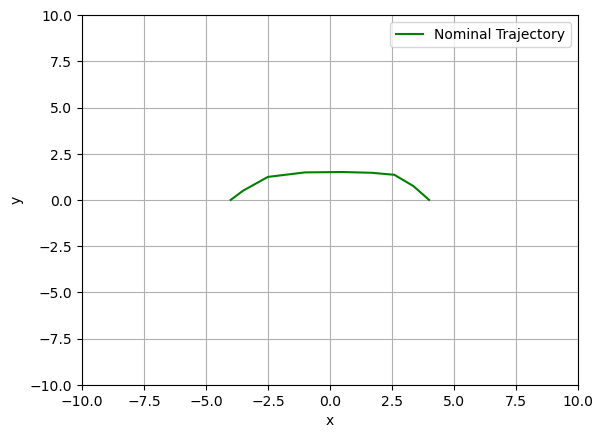

In [ ]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag, kron
import scipy.io as sio
import os
# Parameters
T = 10
Ts = 0.5
state_dim = 4
input_dim = 2
output_dim = 2
disturbance_level_dyn = 0.05
disturbance_level_output = 0.02
response_matrix_bnd = 1e2
Dx = np.eye(state_dim)*disturbance_level_dyn
Dy = np.eye(output_dim)*disturbance_level_output

# The bound of the obstacle box
xu = 3
yu = 1
xl = 3
yl = 1

x_init = np.array([[-4.0], [-0.0], [0.0], [0.0]])  # Initial state
x_terminal = np.array([[4.0], [0.0], [0.0], [0.0]])  # Terminal state


# Dynamics matrices
A_t = np.array([[1, 0, Ts, 0],
                [0, 1, 0, Ts],
                [0, 0, 1, 0],
                [0, 0, 0, 1]], dtype=np.float32)
B_t = np.array([[0, 0],
                [0, 0],
                [Ts, 0],
                [0, Ts]], dtype=np.float32)
C_t = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0]], dtype=np.float32)

# Block-diagonal matrices A, B, C
matrices_A = [A_t if i < T - 1 else np.zeros_like(A_t) for i in range(T)]
matrices_B = [B_t if i < T - 1 else np.zeros_like(B_t) for i in range(T)]
matrices_C = [C_t if i < T - 1 else np.zeros_like(C_t) for i in range(T)]

A = block_diag(kron(np.eye(T-1),A_t), np.zeros_like(A_t))
B = block_diag(kron(np.eye(T-1),B_t), np.zeros_like(B_t))
C = block_diag(kron(np.eye(T-1),C_t), np.zeros_like(C_t))

Id = np.eye(T * state_dim)

# Create Z operator (block downshift)
# Z = np.zeros((T * state_dim, T * state_dim))
# for i in range(1, T):
#     Z[i * state_dim:(i + 1) * state_dim, (i - 1) * state_dim:i * state_dim] = np.eye(state_dim)
Z = kron(np.diag(np.ones(T-1),-1), np.eye(state_dim))

# Define decision variables
phi_xw = cp.Variable((T * state_dim, T * state_dim))
phi_uw = cp.Variable((T * input_dim, T * state_dim))
phi_xe = cp.Variable((T * state_dim, T * output_dim))
phi_ue = cp.Variable((T * input_dim, T * output_dim))

z = cp.Variable((T * state_dim, 1))
v = cp.Variable((T * input_dim, 1))

# Binary variable for the four edges of the obstacle box
# A 4 by 1 vector indicating whether the box edges are active
active_edges = cp.Variable((4, T), boolean=True)


big_M = 1e4 # Big-M value for the box constraints
# Constraints
constraints = []

# Enforce block lower triangular structure
for i in range(T):
    for j in range(i+1, T):
        # constraints += [cp.norm_inf(phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim]) <= np.ones((state_dim, state_dim)) * 1e-2]
        # constraints += [cp.norm_inf(phi_uw[i*input_dim:(i+1)*input_dim, j*state_dim:(j+1)*state_dim]) <= np.ones((input_dim, state_dim)) * 1e-2]
        # constraints += [cp.norm_inf(phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim]) == np.ones((state_dim, output_dim)) * 1e-2]
        # constraints += [cp.norm_inf(phi_ue[i*input_dim:(i+1)*input_dim, j*output_dim:(j+1)*output_dim]) == np.ones((input_dim, output_dim)) * 1e-2]

        constraints += [phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim] ==  np.zeros((state_dim, state_dim))]
        constraints += [phi_uw[i*input_dim:(i+1)*input_dim, j*state_dim:(j+1)*state_dim]  == np.zeros((input_dim, state_dim))]
        constraints += [phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim]  == np.zeros((state_dim, output_dim))]
        constraints += [phi_ue[i*input_dim:(i+1)*input_dim, j*output_dim:(j+1)*output_dim] == np.zeros((input_dim, output_dim))]
        pass
    # constraints.append(phi_xw[i*state_dim:(i+1)*state_dim, (i+1)*state_dim:] == np.zeros((state_dim, (T-i)*state_dim)))
    # constraints.append(phi_uw[i*input_dim:(i+1)*input_dim, (i+1)*state_dim:] == np.zeros((input_dim, (T-i)*state_dim)))
    # constraints.append(phi_xe[i*state_dim:(i+1)*state_dim, (i+1)*output_dim:] == np.zeros((state_dim, (T-i)*output_dim)))
    # constraints.append(phi_ue[i*input_dim:(i+1)*input_dim, (i+1)*output_dim:] == np.zeros((input_dim, (T-i)*output_dim)))

# Tube affine constraints
A_poly = np.array([
    [1, 0, 0, 0],
    [-1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, -1, 0, 0]
])
state_poly_constraint = np.array([1, 5, 2, 2])
input_poly_constraint = np.array([2, 2])
DimAffine = 1  # Only check the first constraint

robust_tube_size_list = []

# Dynamics & robust constraints
for k in range(T - 1):
    z_k = z[k*state_dim:(k+1)*state_dim]
    z_kp1 = z[(k+1)*state_dim:(k+2)*state_dim]
    v_k = v[k*input_dim:(k+1)*input_dim]
    if k <= T-2:
        constraints += [z_kp1 == A_t @ z_k + B_t @ v_k]

    # Initialize the robust tube size variables with zero values
    robust_tube_size_state = 0
    for j in range(k + 1):
        phi_kxwj = phi_xw[k*state_dim:(k+1)*state_dim, j*state_dim:(j+1)*state_dim]
        phi_kxej = phi_xe[k*state_dim:(k+1)*state_dim, j*output_dim:(j+1)*output_dim]
        robust_tube_size_state += cp.abs(C_t @ phi_kxwj @ Dx).sum(axis = 1)
        robust_tube_size_state += cp.abs(C_t @ phi_kxej @ Dy).sum(axis = 1)

    robust_tube_size_input = 0
    for j in range(k + 1):
        phi_kuwj = phi_uw[k*input_dim:(k+1)*input_dim, j*state_dim:(j+1)*state_dim]
        phi_kuej = phi_ue[k*input_dim:(k+1)*input_dim, j*output_dim:(j+1)*output_dim]
        robust_tube_size_input += disturbance_level_dyn * cp.abs(phi_kuwj).sum(axis = 1)
        robust_tube_size_input += disturbance_level_output * cp.abs(phi_kuej).sum(axis = 1)





    constraints += [z_k[0] + robust_tube_size_state[0] <= -xl + big_M * (1 - active_edges[0,k])]
    constraints += [z_k[0] - robust_tube_size_state[0] >= xu - big_M * (1 - active_edges[1,k])]
    constraints += [z_k[1] + robust_tube_size_state[1] <= -yl + big_M * (1 - active_edges[2,k])]
    constraints += [z_k[1] - robust_tube_size_state[1] >= yu - big_M * (1 - active_edges[3,k])]


    # constraints += [z_k[0] <= -xl + big_M * (1 - active_edges[0])]
    # constraints += [z_k[0] >= xu - big_M * (1 - active_edges[1])]
    # constraints += [z_k[1] <= -yl + big_M * (1 - active_edges[2])]
    # constraints += [z_k[1] >= yu - big_M * (1 - active_edges[3])]

    constraints += [v_k[0] + robust_tube_size_input[0] <= input_poly_constraint[0]]
    constraints += [v_k[0] - robust_tube_size_input[0] >= -input_poly_constraint[0]]
    constraints += [v_k[1] + robust_tube_size_input[1] <= input_poly_constraint[1]]
    constraints += [v_k[1] - robust_tube_size_input[1] >= -input_poly_constraint[1]]
    robust_tube_size_list.append(robust_tube_size_state)


    constraints += [cp.sum(active_edges[:,k]) >= 1]  # At least one edge must be active



# P_init = np.zeros((state_dim,state_dim))
# for i in range(T):
#     delta_max_i = cp.abs(C_t@phi_xw[i*state_dim:(i+1)*state_dim, :state_dim]@P_init).sum(axis=1) + \
#                     cp.abs(C_t@phi_xe[i*state_dim:(i+1)*state_dim, :output_dim]@Dy).sum(axis=1) #+ cp.abs(Dy).sum(axis=1)
#     # for j in range(1,T+1):
#     for j in range(1,i+1):
#         # delta_max_i = delta_max_i + cp.abs(phi_x[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim]).sum(axis=1)
#         delta_max_i = delta_max_i + cp.abs(C_t@phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim]@Dx).sum(axis=1) + \
#                                     cp.abs(C_t@phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim]@Dy).sum(axis=1) + \
#                                     0#cp.abs(Dy).sum(axis=1)
    
#     cond1 = (z[state_dim*i] + delta_max_i[0]) - state_poly_constraint[0]
#     constraints.append(cond1 <= 0)


# Initial and terminal constraints
constraints += [z[0:state_dim] == x_init]


# Terminal robust constraint
robust_term_final = 0
for j in range(T):
    phi_Txwj = phi_xw[(T-1)*state_dim:T*state_dim, j*state_dim:(j+1)*state_dim]
    phi_Txej = phi_xe[(T-1)*state_dim:T*state_dim, j*output_dim:(j+1)*output_dim]
    robust_term_final += cp.abs(C_t @ phi_Txwj @ Dx).sum(axis = 1)
    robust_term_final += cp.abs(C_t @ phi_Txej @ Dy).sum(axis = 1)

constraints += [z_k[0] + robust_term_final[0] <= -xl + big_M * (1 - active_edges[0,T-1])]
constraints += [z_k[0] - robust_term_final[0] >= xu - big_M * (1 - active_edges[1,T-1])]
constraints += [z_k[1] + robust_term_final[1] <= -yl + big_M * (1 - active_edges[2,T-1])]
constraints += [z_k[1] - robust_term_final[1] >= yu - big_M * (1 - active_edges[3,T-1])]
constraints += [cp.sum(active_edges[:,T-1]) >= 1]  # At least one edge must be active at the terminal time

# constraints += [cp.sum(active_edges[:,T-1]) >= 1]

z_terminal = z[(T-1)*state_dim:T*state_dim]
# constraints += [A_poly[0] @ z_terminal + robust_term_final <= state_poly_constraint[0]]
# constraints += [z_terminal[0:2] == x_terminal[0:2]]

# SLS constraints
# Phi = cp.hstack([cp.vstack([phi_xw, phi_uw]), cp.vstack([phi_xe, phi_ue])])
# SLS_left = cp.hstack([np.eye(T*state_dim) - Z @ A, -Z @ B])
# constraints += [SLS_left @ Phi == np.hstack([np.eye(T*state_dim), np.zeros((T*state_dim, T*output_dim))])]
# constraints += [Phi @ np.vstack([np.eye(T*state_dim) - Z @ A, -C]) == np.vstack([np.eye(T*state_dim), np.zeros((T*input_dim, T*state_dim))])]

constraints += [(Id - Z@A) @ phi_xw - Z @ B @ phi_uw == Id]
constraints += [(Id - Z@A) @ phi_xe - Z @ B @ phi_ue == np.zeros((T*state_dim, T*input_dim))]
constraints += [phi_xw @ (Id - Z@A) - phi_xe @ C == Id]
constraints += [phi_uw @ (Id - Z@A) - phi_ue @ C == np.zeros((T*input_dim, T*state_dim))]

# Objective
objective = 0
for k in range(T - 1):
    z_k = z[k*state_dim:(k+1)*state_dim]
    z_kp1 = z[(k+1)*state_dim:(k+2)*state_dim]
    objective += cp.sum_squares(z_kp1[0:2] - z_k[0:2])
    objective += 1/T * cp.norm2(z_k[0:2] - x_terminal[0:2])**2
    # objective -= z_k[0]

# Impose a much harsher penalty on the terminal state
objective += 1e3 * cp.norm2(z_terminal[0:2] - x_terminal[0:2])**2
# objective += 1e3* (cp.norm_inf(phi_xw) + cp.norm_inf(phi_xe) + cp.norm_inf(phi_uw) + cp.norm_inf(phi_ue))

# Problem
prob = cp.Problem(cp.Minimize(objective), constraints)
prob.solve(solver=cp.GUROBI, verbose=True)

# Extract solution
z_val = z.value.reshape((state_dim, T), order='F')
v_val = v.value.reshape((input_dim, T), order='F')


# Save the nominal trajectory & input


# Use a valid filename and save in the current working directory
sio.savemat(os.path.join(os.getcwd(), 'z_nominal_val.mat'), {'z_nominal_val': z_val})
sio.savemat(os.path.join(os.getcwd(), 'v_nominal_val.mat'), {'v_nominal_val': v_val})


# Plot
plt.figure()
plt.plot(z_val[0, :], z_val[1, :], 'g', label='Nominal Trajectory')
# plt.axvline(x=state_poly_constraint[0], color='k', linestyle=':')
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid()
plt.show()





In [3]:
z_val[0:2,:].T

array([[-4.00000000e+00,  0.00000000e+00],
       [-4.00000000e+00,  0.00000000e+00],
       [-3.50000000e+00,  4.99999978e-01],
       [-2.50000000e+00,  1.24499998e+00],
       [-1.00000010e+00,  1.49000012e+00],
       [ 5.09050094e-01,  1.50956945e+00],
       [ 1.66941744e+00,  1.46913154e+00],
       [ 2.59654366e+00,  1.35999992e+00],
       [ 3.36523965e+00,  7.50868740e-01],
       [ 3.99938555e+00,  7.48494379e-04]])

In [4]:
# Use a valid filename and save in the current working directory
sio.savemat(os.path.join(os.getcwd(), 'z_nominal_val.mat'), {'z_nominal_val': z_val})
sio.savemat(os.path.join(os.getcwd(), 'v_nominal_val.mat'), {'v_nominal_val': v_val})

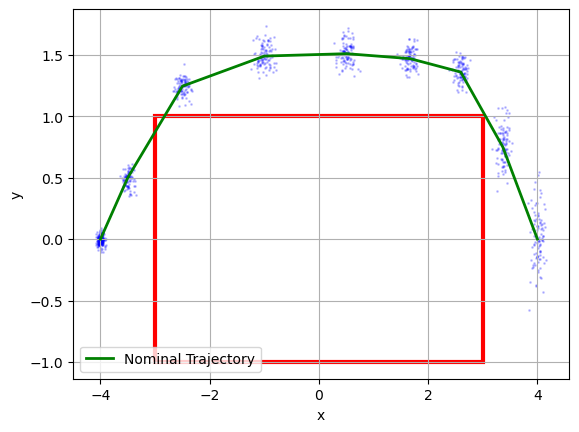

In [5]:
# Roll outs of the nominal trajectory with and without feedback

num_rollout = 100
error_signal_feedback = [None] * num_rollout
error_signal_openloop = [None] * num_rollout
output_trajectory_closedloop = [None] * num_rollout
input_trajectory_closedloop = [None] * num_rollout

unstacked_z = z_val
unstacked_v = v_val

plt.figure()

for rollout_cnt in range(num_rollout):
    # Open-loop rollout (no feedback)
    x = np.zeros((state_dim, T))
    for i in range(T - 1):
        noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        x[:, i + 1] = A_t @ x[:, i] + B_t @ unstacked_v[:, i] + noise
    error_signal_openloop[rollout_cnt] = np.vstack((x[0, :] - unstacked_z[0, :], x[1, :] - unstacked_z[1, :]))

    # Feedback rollout (with feedback)
    val_phi_ue = phi_ue.value.copy()
    val_phi_ue[np.isnan(val_phi_ue)] = 0
    val_phi_uw = phi_uw.value.copy()
    val_phi_uw[np.isnan(val_phi_uw)] = 0
    val_phi_xe = phi_xe.value
    val_phi_xw = phi_xw.value

    # Ensure the matrices are lower triangular
    # val_phi_xw = np.tril(val_phi_xw)
    # val_phi_xe = np.tril(val_phi_xe)
    # val_phi_uw = np.tril(val_phi_uw)
    # val_phi_ue = np.tril(val_phi_ue)
    # val_phi_xw = np.tril(val_phi_xw)



    # Feedback gain
    K = val_phi_ue - val_phi_uw @ np.linalg.solve(val_phi_xw, val_phi_xe)

    # Apply initial condition with disturbance
    x_init_fb = x_init + disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1).reshape((state_dim, 1))
    x_fb = np.zeros((state_dim, T))
    y_fb = np.zeros((output_dim, T))
    x_fb[:, 0] = x_init_fb.flatten()
    feedback_u = np.zeros((input_dim, T))

    for i in range(T):
        feedback_control = np.zeros(input_dim)
        y_fb[:, i] = C_t @ x_fb[:, i] + disturbance_level_output * (np.random.rand(output_dim) * 2 - 1)
        for j in range(i + 1):
            idx_K_row = slice(i * input_dim, (i + 1) * input_dim)
            idx_K_col = slice(j * output_dim, (j + 1) * output_dim)
            feedback_control += K[idx_K_row, idx_K_col] @ (y_fb[:, j] - C_t @ unstacked_z[:, j])
        dynamics_noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1)
        if i < T - 1:
            x_fb[:, i + 1] = A_t @ x_fb[:, i] + B_t @ (feedback_control + unstacked_v[:, i]) + dynamics_noise
        feedback_u[:, i] = feedback_control
        

    plt.scatter(x_fb[0, :], x_fb[1, :], color="b", alpha=0.2, s = 1)
    error_signal_feedback[rollout_cnt] = np.vstack((x_fb[0, :] - unstacked_z[0, :], x_fb[1, :] - unstacked_z[1, :]))
    output_trajectory_closedloop[rollout_cnt] = y_fb
    input_trajectory_closedloop[rollout_cnt] = feedback_u

# Save the feedback gain K
# sio.savemat('K_forward_game.mat', {'K_forward': K})

plt.plot(unstacked_z[0, :], unstacked_z[1, :], color="g", label="Nominal Trajectory", linewidth=2)
# plt.axvline(x=state_poly_constraint[0], linestyle=":", color="k", linewidth=2)
plt.xlabel('x')
plt.ylabel('y')
plt.legend()


# Plot a box with half size [xu, yu] centered at the origin
# Using patch to draw the box, plot on existing figure
import matplotlib.patches as patches
box = patches.Rectangle((-xu, -yu), 2*xu, 2*yu
, linewidth= 3, edgecolor='r', facecolor='none')
plt.gca().add_patch(box)
plt.grid()
plt.show()

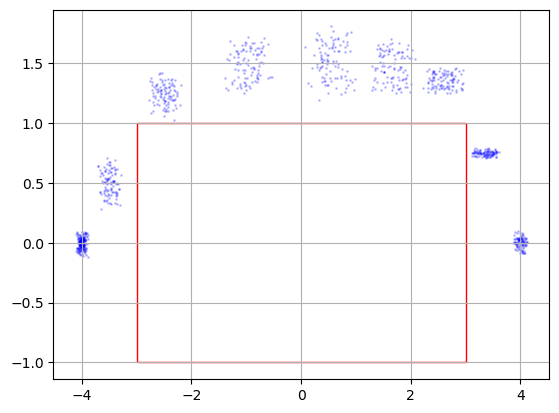

In [6]:
# Roll out directly with Phi matrices (not using K)
# num_rollout = 100
# error_signal_feedback = [None] * num_rollout
# error_signal_openloop = [None] * num_rollout
# output_trajectory_closedloop = [None] * num_rollout
# input_trajectory_closedloop = [None] * num_rollout

for rollout_cnt in range(num_rollout):
    x_fb = np.zeros((state_dim, T))
    # y_fb = np.zeros((output_dim, T))
    delta_x = np.zeros((state_dim, T))
    y_fb = np.zeros((output_dim, T))
    # delta_y = np.zeros((output_dim, T))
    x_fb[:, 0] = x_init.flatten() + disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1).reshape((state_dim, 1)).flatten()
    # y_fb[:, 0] = C_t @ x_fb[:, 0] + disturbance_level_output * (np.random.rand(output_dim) * 2 - 1).reshape((output_dim, 1))
    for i in range(T):
        dyn_noise = disturbance_level_dyn * (np.random.rand(state_dim) * 2 - 1).reshape((state_dim, 1))
        obs_noise = disturbance_level_output * (np.random.rand(output_dim) * 2 - 1).reshape((output_dim, 1))
        for j in range(i + 1):
            val_phi_xw_slice = val_phi_xw[i*state_dim:(i+1)*state_dim, j*state_dim:(j + 1)*state_dim]
            val_phi_xe_slice = val_phi_xe[i*state_dim:(i+1)*state_dim, j*output_dim:(j + 1)*output_dim]
            delta_x[:, i] += (val_phi_xw_slice @ dyn_noise).flatten() + (val_phi_xe_slice @ obs_noise).flatten()
        x_fb[:,i] = unstacked_z[:, i] + delta_x[:,i]
    # plt.plot(x_fb[0, :], x_fb[1, :], "b", alpha=0.2)
    # Plot the scatter plot of the feedback trajectory
    plt.scatter(x_fb[0, :], x_fb[1, :], color='blue', alpha=0.2, s=1)
box = patches.Rectangle((-xu, -yu), 2*xu, 2*yu
, linewidth=1, edgecolor='r', facecolor='none')
plt.gca().add_patch(box)
plt.grid()
plt.show()


In [7]:
x_init

array([[-4.],
       [-0.],
       [ 0.],
       [ 0.]])

In [8]:
# Verify if K is lower triangular
if np.allclose(K, np.tril(K)):
    print("K is lower triangular.")
else:
    print("K is not lower triangular.")

print(np.linalg.norm(K - np.tril(K), ord='fro'))

K is not lower triangular.
0.00029654636678942947


In [9]:
# constraints += [(Id - Z@A) @ phi_xw - Z @ B @ phi_uw == Id]
# constraints += [(Id - Z@A) @ phi_xe - Z @ B @ phi_ue == np.zeros((T*input_dim, T*state_dim))]
# constraints += [phi_xw @ (Id - Z@A) - phi_xe @ C == Id]
# constraints += [phi_uw @ (Id - Z@A) - phi_ue @ C == np.zeros((T*input_dim, T*state_dim))]

# Display the sizes of the matrices
print("Size of phi_xw:", phi_xw.shape)
print("Size of phi_uw:", phi_uw.shape)  
print("Size of phi_xe:", phi_xe.shape)
print("Size of phi_ue:", phi_ue.shape)
# Display the sizes of the matrices Id, Z, A ,B and their products in the constraints
print("Size of Id:", Id.shape)
print("Size of Z:", Z.shape)
print("Size of A:", A.shape)
print("Size of B:", B.shape)
print("Size of (Id - Z@A):", (Id - Z@A).shape)
# Display the sizes of the products in the constraints
print("Size of (Id - Z@A) @ phi_xw:", ((Id - Z@A) @ phi_xw).shape)
print("Size of Z @ B @ phi_uw:", (Z @ B @ phi_uw).shape)
print("Size of (Id - Z@A) @ phi_xe:", ((Id - Z@A) @ phi_xe).shape)
print("Size of Z @ B @ phi_ue:", (Z @ B @ phi_ue).shape)

Size of phi_xw: (40, 40)
Size of phi_uw: (20, 40)
Size of phi_xe: (40, 20)
Size of phi_ue: (20, 20)
Size of Id: (40, 40)
Size of Z: (40, 40)
Size of A: (40, 40)
Size of B: (40, 20)
Size of (Id - Z@A): (40, 40)
Size of (Id - Z@A) @ phi_xw: (40, 40)
Size of Z @ B @ phi_uw: (40, 40)
Size of (Id - Z@A) @ phi_xe: (40, 20)
Size of Z @ B @ phi_ue: (40, 20)


In [10]:
[item.value for item in robust_tube_size_list]

[array([0.05, 0.05]),
 array([0.125, 0.125]),
 array([0.225, 0.225]),
 array([0.35 , 0.245]),
 array([0.50000002, 0.48999993]),
 array([0.50496104, 0.50956905]),
 array([0.4788571 , 0.42365052]),
 array([0.46104248, 0.36000001]),
 array([0.43109206, 0.86969935])]

In [11]:
max(phi_ue.value.reshape(-1,order="F"))

np.float64(11.243089704096562)

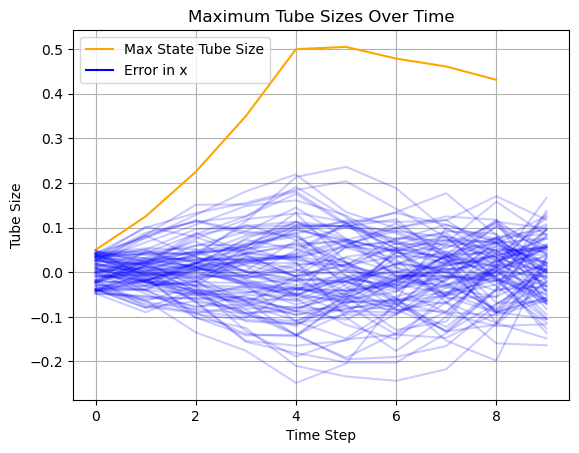

In [12]:
# Reachability analysis using the computed feedback gain
# Instantiate the noise value as decision variables

w = cp.Variable((T * state_dim, 1))
e = cp.Variable((T * output_dim, 1))

# Maximum tube size at each time step, use a list instead of a NumPy array
max_state_tube_size = []
max_input_tube_size = []
# Initialize the maximum tube sizes as zero
for k in range(T - 1):
    max_state_tube_size.append(0)
    max_input_tube_size.append(0)

# Instantiate the results container of the maximum tube sizes
val_max_state_tube_size = np.zeros((T, 1))
val_max_state_tube_size = np.zeros((T, 1))
constraints = []

constraints += [cp.norm_inf(w) <= disturbance_level_dyn]
constraints += [cp.norm_inf(e) <= disturbance_level_output]

# Compute the maximum tube size
for k in range(T - 1):  

    # Bound the infinity norm of the noise level
    max_state_tube_size[k] = 0
    max_input_tube_size[k] = 0
    
    for j in range(k + 1):


        w_j = w[j*state_dim:(j+1)*state_dim]
        e_j = e[j*output_dim:(j+1)*output_dim]


        phi_kxwj = val_phi_xw[k*state_dim:(k+1)*state_dim, j*state_dim:(j+1)*state_dim]
        phi_kxej = val_phi_xe[k*state_dim:(k+1)*state_dim, j*output_dim:(j+1)*output_dim]
        phi_kuwj = val_phi_uw[k*input_dim:(k+1)*input_dim, j*state_dim:(j+1)*state_dim]
        phi_kuej = val_phi_ue[k*input_dim:(k+1)*input_dim, j*output_dim:(j+1)*output_dim]

        # Compute the maximum state tube size

        max_state_tube_size[k] = max_state_tube_size[k] + disturbance_level_dyn * np.abs(phi_kxwj[0,:]) @ np.ones((state_dim,)) + disturbance_level_output * np.abs(phi_kxej[0,:]) @ np.ones((output_dim,))
        # Compute the maximum input tube size
        max_input_tube_size[k] = max_input_tube_size[k] + phi_kuwj @ w_j + phi_kuej @ e_j


        # max_state_tube_size[k] = max_state_tube_size[k] + phi_kxwj @ w_j + phi_kxej @ e_j
        # # Compute the maximum input tube size
        # max_input_tube_size[k] = max_input_tube_size[k] + phi_kuwj @ w_j + phi_kuej @ e_j
    
    # Maximize the tube sizes via cvxpy, which is done at each time step
    # We need to generate a cvxproblem and solve it
    # Add the constraints to the problem
    # Use the epigraph trick to avoid DCP problems
    # constraints += [t >= max_input_tube_size[k]]
    # Define the problem

    # prob_state = cp.Problem(cp.Maximize(cp.norm(max_state_tube_size[k])), constraints)
    # prob_state.solve(solver=cp.GUROBI, verbose=False)
    # val_max_state_tube_size[k] = max_state_tube_size[k].value




# Plot the maximum tube sizes at different time steps, plot the error signal of the rollouts
plt.figure(1)
plt.plot([expr for expr in max_state_tube_size], label='Max State Tube Size', color='orange')
# plt.plot([expr.value for expr in max_input_tube_size], label='Max Input Tube Size', color='blue')
plt.xlabel('Time Step')
plt.ylabel('Tube Size')
plt.title('Maximum Tube Sizes Over Time')
plt.legend()
plt.grid()

# Plot the error signals of the rollouts
for rollout_cnt in range(num_rollout):
    plt.plot(error_signal_feedback[rollout_cnt][0, :], 'b', alpha=0.2)
    # plt.plot(error_signal_feedback[rollout_cnt][1, :], 'r', alpha=0.2)
plt.plot([], [], 'b', label='Error in x')
# plt.plot([], [], 'r', label='Error in y')
plt.legend()
plt.show() 

# plt.figure(3)
# for rollout_cnt in range(num_rollout):
#     plt.plot(error_signal_openloop[rollout_cnt][0, :], error_signal_openloop[rollout_cnt][1, :], 'r', alpha=0.2)
# plt.xlabel('Error in x')
# plt.ylabel('Error in y')
# plt.title('Error Signal of Open-loop Rollouts')
# plt.grid()
# plt.show()


In [13]:
# check if val_phi_xw is ill-conditioned
if np.linalg.cond(val_phi_xw) > 1 / np.finfo(float).eps:
    print("val_phi_xw is ill-conditioned.")
else:
    print("val_phi_xw is well-conditioned.")    


val_phi_xw is well-conditioned.


In [14]:
unstacked_z[0:2,:].T

array([[-4.00000000e+00,  0.00000000e+00],
       [-4.00000000e+00,  0.00000000e+00],
       [-3.50000000e+00,  4.99999978e-01],
       [-2.50000000e+00,  1.24499998e+00],
       [-1.00000010e+00,  1.49000012e+00],
       [ 5.09050094e-01,  1.50956945e+00],
       [ 1.66941744e+00,  1.46913154e+00],
       [ 2.59654366e+00,  1.35999992e+00],
       [ 3.36523965e+00,  7.50868740e-01],
       [ 3.99938555e+00,  7.48494379e-04]])

In [15]:
output_trajectory_closedloop[rollout_cnt]
input_trajectory_closedloop[rollout_cnt]



array([[ 6.17669834e-12,  6.72756121e-12,  3.79562087e-10,
         3.31906941e-01,  2.78317547e-02, -4.68624012e-02,
         2.16351176e-01,  1.28047309e-01, -1.75960787e-01,
         0.00000000e+00],
       [ 1.95673262e-09,  1.15770789e-01,  4.40462336e-08,
        -8.43601871e-02, -1.01762985e-01,  2.42344236e-01,
         9.36852065e-12, -5.58857353e-06, -1.75960787e-01,
         0.00000000e+00]])

In [16]:
# Time to implement the inverse game!
# First we need to invert K from the demonstrations


Y = np.zeros((output_dim * T, num_rollout - 1))
U = np.zeros((input_dim * T, num_rollout - 1))

for t in range(T):
    y_diff_unstacked = np.zeros((output_dim, num_rollout - 1))
    u_diff_unstacked = np.zeros((input_dim, num_rollout - 1))
    for rc in range(num_rollout - 1):
        # Assuming state_trajectory_closedloop is available as a list of arrays [num_rollout][state_dim, T]
        y_diff = output_trajectory_closedloop[rc + 1][:, t] - output_trajectory_closedloop[rc][:, t]
        u_diff = input_trajectory_closedloop[rc + 1][:, t] - input_trajectory_closedloop[rc][:, t]
        y_diff_unstacked[:, rc] = y_diff
        u_diff_unstacked[:, rc] = u_diff
    Y[t * output_dim:(t + 1) * output_dim, :] = y_diff_unstacked
    U[t * input_dim:(t + 1) * input_dim, :] = u_diff_unstacked

# This is supposed to be a lower triangular matrix
# Solve K via linear programming
Kinv = cp.Variable((input_dim * T, output_dim * T), nonneg=True)
objective = 1e3 * cp.Minimize(cp.norm(Kinv @ Y - U, 'fro'))
# Ensure Kinv is lower triangular by setting upper-triangular entries to zero
# lower_tri_mask = np.tril(np.ones((input_dim * T, output_dim * T)))
# constraints = [cp.multiply(1 - lower_tri_mask, Kinv) == 0]  # Kinv must be lower triangular
prob_inverse = cp.Problem(objective, constraints)
# prob_inverse.solve(solver=cp.GUROBI, verbose=True)

Kinv = Kinv.value
Kinv = U @ np.linalg.pinv(Y)  # Use pseudo-inverse to compute Kinv
# sio.savemat('K_inverse_game.mat', {'K_inverse': Kinv})

In [17]:
np.linalg.norm(K - Kinv, ord='fro')

np.float64(1.0874159606888105e-13)

In [18]:
np.eye(3,3)

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [19]:
# Solving for the phi matrices from K
phi_xw_inv = cp.Variable((T * state_dim, T * state_dim))
phi_uw_inv = cp.Variable((T * input_dim, T * state_dim))
phi_xe_inv = cp.Variable((T * state_dim, T * output_dim))
phi_ue_inv = cp.Variable((T * input_dim, T * output_dim))

# Include two auxiliary matrices for the solving
phi_yw_inv = cp.Variable((T * output_dim, T * state_dim))
phi_ye_inv = cp.Variable((T * output_dim, T * output_dim))

# Formulate the constraints
constraints = []

constraints += [(Id - Z @ A) @ phi_xw_inv - Z @ B @ phi_uw_inv == Id]
constraints += [(Id - Z @ A) @ phi_xe_inv - Z @ B @ phi_ue_inv == np.zeros((T * state_dim, T * input_dim))]
constraints += [-C @ phi_xw_inv + phi_yw_inv == np.zeros((T * output_dim, T * state_dim))]
constraints += [-C @ phi_xe_inv + phi_ye_inv == np.eye(T * output_dim, T * output_dim)]
constraints += [-phi_uw_inv + Kinv @ phi_yw_inv == np.zeros((T * input_dim, T * state_dim))]
constraints += [-phi_ue_inv + Kinv @ phi_ye_inv == np.zeros((T * input_dim, T * output_dim))]

# Enforce block lower triangular structure
for i in range(T):
    for j in range(i+1, T):
        constraints += [phi_xw_inv[i*state_dim:(i+1)*state_dim, j*state_dim:(j+1)*state_dim] ==  np.zeros((state_dim, state_dim))]
        constraints += [phi_uw_inv[i*input_dim:(i+1)*input_dim, j*state_dim:(j+1)*state_dim]  == np.zeros((input_dim, state_dim))]
        constraints += [phi_xe_inv[i*state_dim:(i+1)*state_dim, j*output_dim:(j+1)*output_dim]  == np.zeros((state_dim, output_dim))]
        constraints += [phi_ue_inv[i*input_dim:(i+1)*input_dim, j*output_dim:(j+1)*output_dim] == np.zeros((input_dim, output_dim))]
        constraints += [phi_yw_inv[i*output_dim:(i+1)*output_dim, j*state_dim:(j+1)*state_dim] == np.zeros((output_dim, state_dim))]
        constraints += [phi_ye_inv[i*output_dim:(i+1)*output_dim, j*output_dim:(j+1)*output_dim] == np.zeros((output_dim, output_dim))]

# Objective function
# This is a feasibility problem, so we can set the objective to zero
objective = cp.Minimize(0)
# Problem
prob_phi = cp.Problem(objective, constraints)
prob_phi.solve(solver=cp.GUROBI, verbose=True)
# Extract the values of the phi matrices
phi_xw_inv_val = phi_xw_inv.value
phi_uw_inv_val = phi_uw_inv.value
phi_xe_inv_val = phi_xe_inv.value
phi_ue_inv_val = phi_ue_inv.value
phi_yw_inv_val = phi_yw_inv.value
phi_ye_inv_val = phi_ye_inv.value

# Compare the computed phi matrices with the original ones
print("Norm of phi_xw - phi_xw_inv:", np.linalg.norm(phi_xw.value - phi_xw_inv_val, ord='fro'))
print("Norm of phi_uw - phi_uw_inv:", np.linalg.norm(phi_uw.value - phi_uw_inv_val, ord='fro'))
print("Norm of phi_xe - phi_xe_inv:", np.linalg.norm(phi_xe.value - phi_xe_inv_val, ord='fro'))
print("Norm of phi_ue - phi_ue_inv:", np.linalg.norm(phi_ue.value - phi_ue_inv_val, ord='fro'))

# Save the computed phi matrices
import os

# Use a valid file path, e.g., save to the current working directory
save_path = os.path.join(os.getcwd(), "phi_matrices_inverse_game.mat")
sio.savemat(save_path, {
    'phi_xw_inv': phi_xw_inv_val,
    'phi_uw_inv': phi_uw_inv_val,
    'phi_xe_inv': phi_xe_inv_val,
    'phi_ue_inv': phi_ue_inv_val,
    'phi_yw_inv': phi_yw_inv_val,
    'phi_ye_inv': phi_ye_inv_val
})



(CVXPY) Jul 31 06:38:56 PM: Your problem has 4800 variables, 6960 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 31 06:38:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 31 06:38:56 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 31 06:38:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 31 06:38:56 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 31 06:38:56 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 31 06:38:56 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Jul 31 06:38:56 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 31 06:38:56 PM: Applying reduction Qp2SymbolicQp
(CVXPY) Jul 31 06:38:56 PM: Applying reduction QpMatrixStuffing
(CVXPY) Jul 31 06:38:56 PM: Applying reduction GUROBI
(CVXPY) Jul 31 06:38:56 PM: Finished problem compilation (took 6.431e-02 seconds).
(CVXPY) Jul 31 06:38:56 PM: Invoking solver GUROBI  to obtain a

-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
QCPDual  1

Optimize a model with 6960 rows, 4800 columns and 21180 nonzeros
Model fingerprint: 0x4c2dd0

(CVXPY) Jul 31 06:38:56 PM: Problem status: optimal
(CVXPY) Jul 31 06:38:56 PM: Optimal value: 0.000e+00
(CVXPY) Jul 31 06:38:56 PM: Compilation took 6.431e-02 seconds
(CVXPY) Jul 31 06:38:56 PM: Solver (including time spent in interface) took 3.989e-02 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
Norm of phi_xw - phi_xw_inv: 1.4136930529636484e-05
Norm of phi_uw - phi_uw_inv: 2.0844535887371952e-05
Norm of phi_xe - phi_xe_inv: 1.217435152473075e-05
Norm of phi_ue - phi_ue_inv: 1.3982786969473089e-05


In [20]:
# Solve for the nominal trajectory using the computed phi matrices
z_nominal = cp.Variable((T * state_dim, 1))
v_nominal = cp.Variable((T * input_dim, 1))

# Constraints for the nominal trajectory
constraints_nominal = []
# Initial condition
residual = 0
constraints_nominal += [z_nominal[0:state_dim] == x_init]
constraints_nominal += [z_nominal[(T-1)*state_dim:T*state_dim] == z_val[:,-1].reshape((state_dim,1))]  # Terminal condition 
constraints_nominal += [v_nominal[(T-2)*input_dim:(T-1)*input_dim] == v_val[:,-2].reshape((input_dim,1))]  # Terminal input condition

# Dynamics constraints
for rollout_cnt in range(num_rollout):
    for k in range(T):
        if k < T - 1:
            z_k = z_nominal[k*state_dim:(k+1)*state_dim]
            z_kp1 = z_nominal[(k+1)*state_dim:(k+2)*state_dim]
            v_k = v_nominal[k*input_dim:(k+1)*input_dim]

            constraints_nominal += [z_kp1 == A_t @ z_k + B_t @ v_k]

        # Compute the feedback term
        feedback_control = np.zeros(input_dim)
        for j in range(k+1):
            idx_K_row = slice(k * input_dim, (k + 1) * input_dim)
            idx_K_col = slice(j * output_dim, (j + 1) * output_dim)
            feedback_control = feedback_control + Kinv[idx_K_row, idx_K_col] @ (output_trajectory_closedloop[rollout_cnt][:, j].reshape((output_dim,1)) - C_t @ z_nominal[j*state_dim:(j+1)*state_dim])
            # print("Feedback control shape:", feedback_control.shape)
        # The feedback control should match the input_trajectory_closedloop
        # constraints_nominal += [input_trajectory_closedloop[rollout_cnt][:, k] - feedback_control == 0]
        residual = residual + cp.norm1(input_trajectory_closedloop[rollout_cnt][:, k].reshape((input_dim,1)) - feedback_control)



# Sanity check for the nominal trajectory
# constraints_nominal += [z_nominal == z.value]

# Feasebility problem to find the nominal trajectory
objective_nominal = cp.Minimize(residual)
# Problem for the nominal trajectory
prob_nominal = cp.Problem(objective_nominal, constraints_nominal)
prob_nominal.solve(solver=cp.GUROBI, verbose=True)

z_nominal_val = z_nominal.value.reshape((state_dim, T), order='F')
# Compare the nominal trajectory with the original one
print("Norm of nominal trajectory - original trajectory:", np.linalg.norm(z_nominal_val - z_val, ord='fro'))

c:\Users\zhang\anaconda3\envs\robotics-opt-env\lib\site-packages\cvxpy\problems\problem.py:158: UserWarning: Objective contains too many subexpressions. Consider vectorizing your CVXPY code to speed up compilation.
  warnings.warn("Objective contains too many subexpressions. "
(CVXPY) Jul 31 06:38:58 PM: Your problem has 60 variables, 3610 constraints, and 0 parameters.


                                     CVXPY                                     
                                     v1.6.6                                    


(CVXPY) Jul 31 06:38:58 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 31 06:38:58 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 31 06:38:58 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jul 31 06:38:58 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Jul 31 06:38:58 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jul 31 06:38:58 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> GUROBI
(CVXPY) Jul 31 06:38:58 PM: Applying reduction CvxAttr2Constr
(CVXPY) Jul 31 06:38:58 PM: Applying reduction Qp2SymbolicQp


-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Jul 31 06:38:59 PM: Applying reduction QpMatrixStuffing
(CVXPY) Jul 31 06:39:01 PM: Applying reduction GUROBI
(CVXPY) Jul 31 06:39:01 PM: Finished problem compilation (took 3.516e+00 seconds).
(CVXPY) Jul 31 06:39:01 PM: Invoking solver GUROBI  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
Set parameter OutputFlag to value 1
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
Set parameter QCPDual to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: 13th Gen Intel(R) Core(TM) i9-13980HX, instruction set [SSE2|AVX|AVX2]
Thread count: 24 physical cores, 32 logical processors, using up to 32 threads

Non-default parameters:
QCPDual  1

Optimize a model with 7610 rows, 2060 columns and 44210 nonzeros
Model fingerprint: 0xb17a9154
Coefficient statistics:
  Matrix range     [2e-10, 1e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-10, 1e+01]
Presolve removed 6310 rows and 748 columns
Presolve time: 0.01s
Presolved: 13

(CVXPY) Jul 31 06:39:02 PM: Problem status: optimal
(CVXPY) Jul 31 06:39:02 PM: Optimal value: 9.420e-12
(CVXPY) Jul 31 06:39:02 PM: Compilation took 3.516e+00 seconds
(CVXPY) Jul 31 06:39:02 PM: Solver (including time spent in interface) took 4.673e-02 seconds


-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
Norm of nominal trajectory - original trajectory: 6.391640674406922


In [21]:
z_nominal_val.T

array([[-4.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.00000000e+00,  0.00000000e+00,  9.99999999e-01,
         9.99999957e-01],
       [-3.50000000e+00,  4.99999978e-01,  1.99999999e+00,
         1.48999999e+00],
       [-2.50000000e+00,  1.24499998e+00,  2.99999981e+00,
         4.90000280e-01],
       [-1.00000010e+00,  1.49000012e+00,  3.01810038e+00,
         3.91386696e-02],
       [ 5.09050094e-01,  1.50956945e+00,  2.32073469e+00,
         2.20593746e+00],
       [ 1.66941744e+00,  2.61253818e+00,  1.85425243e+00,
        -5.22507636e+00],
       [ 2.59654366e+00,  0.00000000e+00,  1.53739199e+00,
         1.50173748e+00],
       [ 3.36523965e+00,  7.50868740e-01,  1.26829180e+00,
        -1.50024049e+00],
       [ 3.99938555e+00,  7.48494379e-04,  1.26829180e+00,
        -1.50024049e+00]])

In [22]:
z_val.T

array([[-4.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-4.00000000e+00,  0.00000000e+00,  9.99999999e-01,
         9.99999957e-01],
       [-3.50000000e+00,  4.99999978e-01,  1.99999998e+00,
         1.49000000e+00],
       [-2.50000000e+00,  1.24499998e+00,  2.99999982e+00,
         4.90000280e-01],
       [-1.00000010e+00,  1.49000012e+00,  3.01810038e+00,
         3.91386671e-02],
       [ 5.09050094e-01,  1.50956945e+00,  2.32073469e+00,
        -8.08758270e-02],
       [ 1.66941744e+00,  1.46913154e+00,  1.85425244e+00,
        -2.18263227e-01],
       [ 2.59654366e+00,  1.35999992e+00,  1.53739199e+00,
        -1.21826237e+00],
       [ 3.36523965e+00,  7.50868740e-01,  1.26829180e+00,
        -1.50024049e+00],
       [ 3.99938555e+00,  7.48494379e-04,  1.26829180e+00,
        -1.50024049e+00]])

In [23]:
Kinv[4*input_dim:5*input_dim,:].T


array([[-1.58874965e-01, -1.27207663e-04],
       [-1.86696768e-03,  1.16099134e-02],
       [-1.86460148e-01, -1.27300517e-04],
       [ 7.04900315e-04, -5.64129425e+00],
       [-3.96964760e-02, -4.37823438e-05],
       [ 2.27703815e-04,  7.83147909e-01],
       [ 2.83751080e+00,  1.10003051e-05],
       [-3.41007493e-04,  5.66882020e+00],
       [-2.33974425e+00,  4.95093391e-05],
       [-5.90858647e-05, -5.62154416e+00],
       [-6.02768961e-16,  4.00416686e-15],
       [-5.14142207e-15, -9.14317159e-15],
       [-5.60024167e-16, -1.28545364e-16],
       [ 2.00315385e-15,  5.45735289e-15],
       [ 1.79022447e-15, -1.49210091e-16],
       [-2.55646129e-17, -3.02263643e-15],
       [-2.18181065e-15,  4.13751845e-15],
       [-1.60136160e-15, -2.11574696e-15],
       [ 1.02144516e-15, -3.73861717e-15],
       [ 4.23692797e-16,  9.60656761e-16]])